In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import  average_precision_score, classification_report, accuracy_score, log_loss, hinge_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures  
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [48]:
df1 = pd.read_csv("Data2017-2020 .csv")
df2 = pd.read_csv("Data2020-2023.csv")
#Concating our two data frames
data = pd.concat([df1,df2])
df4 = pd.concat([df1,df2])
n_rawDataPoints = data.shape[0] #The amount of raw data points
#Creating a single "datetime" column from the data's year, month and day data.
data = data.assign(datetime = data["Vuosi"].astype(str)+'-'+data["Kk"].astype(str)+'-'+data["Pv"].astype(str))
#Excludint the unnecessary columns from the data set.
data = data.drop(['Aikavyöhyke','Vuosi','Kk','Pv','Klo'],axis=1)  
data['datetime'] = pd.to_datetime(data['datetime'])

data = data.rename(columns={   #Renaming all of the columns to English
                            'Ilmanpaine (msl) (hPa)' :'Air Pressure (hPa)',
                            'Sademäärä (mm)':'Precipitation (mm)',
                            'Suhteellinen kosteus (%)': 'Humidity (%)',
                            'Tuulen nopeus (m/s)' : 'Wind speed (m/s)',
                            'Ilman lämpötila (degC)' : 'Temperature (degC)' })

#Forcing all of the datapoints to numeric values
numeric_columns = [col for col in data.columns if col != 'datetime']
for column in numeric_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')
#We'll notice that the data contains many NaNs.
#We can replace NaNs from the hourly data with forward fill:
data.fillna(method='ffill', inplace=True)

#Grouping all of the data by the "datetime" column's values 
#Then calculating the daily average values for the feature values.
data_avrg = data.groupby(data['datetime']).mean().reset_index()
n_DataPoints = data_avrg.shape[0]
#Creating the binary data for a given day being rainy or not
data_avrg['Total precipitation (mm)'] = data_avrg['Precipitation (mm)'] * 24
data_avrg['Is rainy'] = (data_avrg['Total precipitation (mm)'] >= 1).astype(int)

n_rainyDays = sum(data_avrg['Is rainy'])


In [49]:

df3 = data_avrg[['Air Pressure (hPa)', 'Humidity (%)', 'Is rainy','Wind speed (m/s)', 'Temperature (degC)']]
df3 = df3.rename(columns={  'Is rainy' : 'IR',
                            'Air Pressure (hPa)' : 'AP',
                            'Humidity (%)': 'H',
                            'Wind speed (m/s)' : 'WS',
                            'Temperature (degC)' : 'T'})
matrix = df3.corr()
print(matrix)

          AP         H        IR        WS         T
AP  1.000000 -0.346764 -0.456409 -0.316105  0.094665
H  -0.346764  1.000000  0.495886  0.148782 -0.341849
IR -0.456409  0.495886  1.000000  0.278073 -0.115520
WS -0.316105  0.148782  0.278073  1.000000 -0.110512
T   0.094665 -0.341849 -0.115520 -0.110512  1.000000


0.8041002277904328


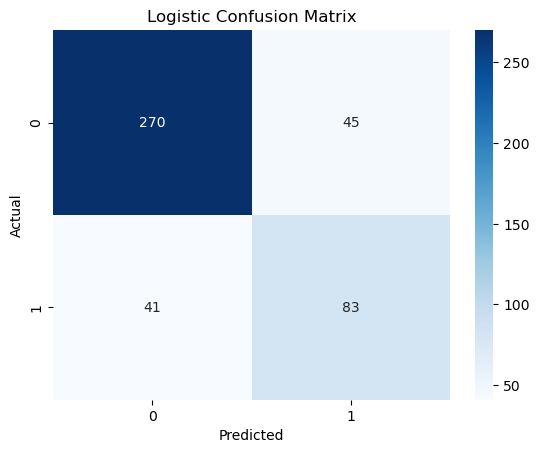

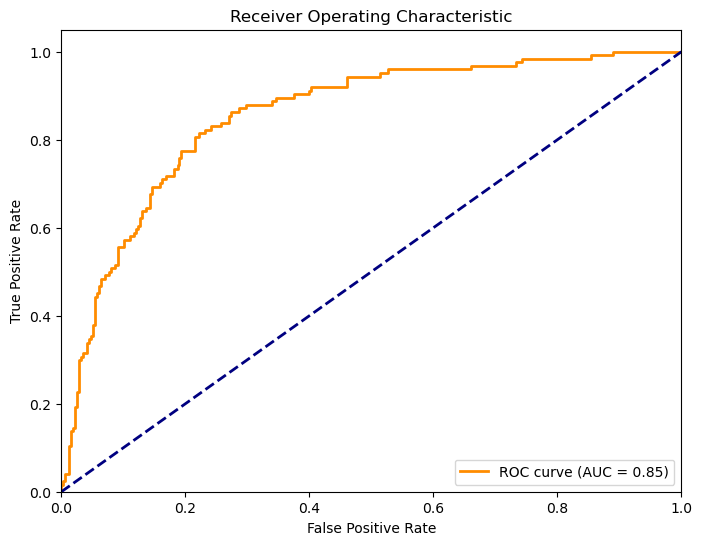

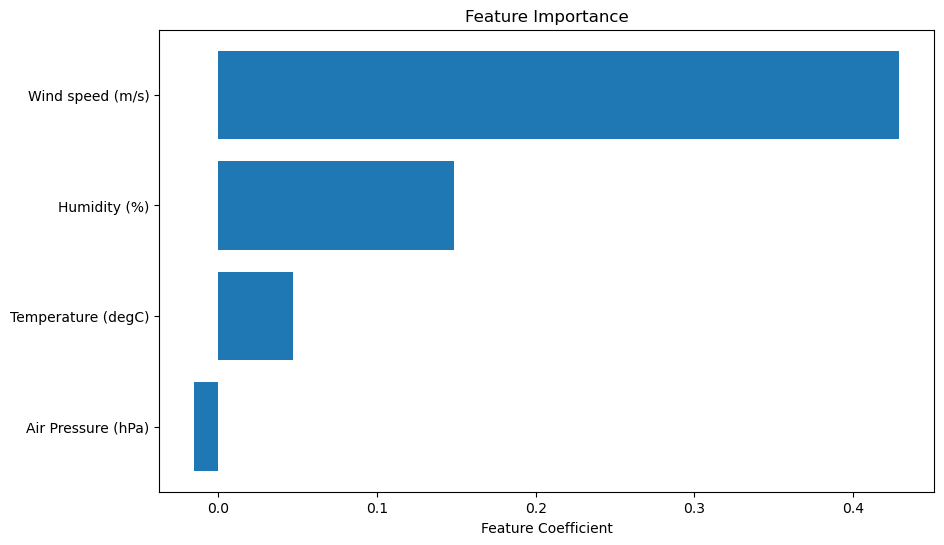

In [50]:
y = data_avrg['Is rainy']
X = data_avrg[['Air Pressure (hPa)', 'Humidity (%)','Wind speed (m/s)', 'Temperature (degC)']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train,y_train)

y_pred_train = clf.predict(X_train)

tr_log_loss = log_loss(y_train,y_pred_train)

y_pred_val =clf.predict(X_val)

val_log_loss = log_loss(y_val,y_pred_val)

y_pred_test = clf.predict(X_test)

test_log_loss = log_loss(y_test, y_pred_test)

accuracy_Logistic = accuracy_score(y_val, y_pred_val)

# Confusion Matrix

conf_matrix = confusion_matrix(y_val, y_pred_val)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Confusion Matrix')
plt.savefig("LogisticConfusionMatrix.png")

# ROC Curve
y_prob = clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig("LogisticROC.png") # save as png

# Feature Importance
# Sort features by their coefficients
coef = clf.coef_[0]
feature_names = X.columns
coef_indices = np.argsort(coef)

# Create a bar plot with sorted features
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in coef_indices], coef[coef_indices], align='center')
plt.xlabel('Feature Coefficient')
plt.title('Feature Importance')
plt.savefig("LogisticFeatureImportance.png") # save as png

print(accuracy_Logistic)

0.8291571753986332


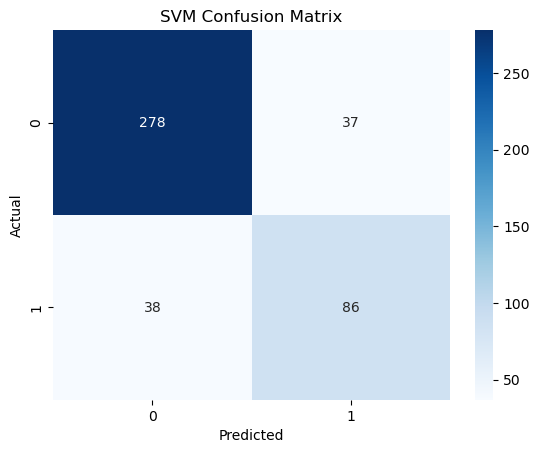

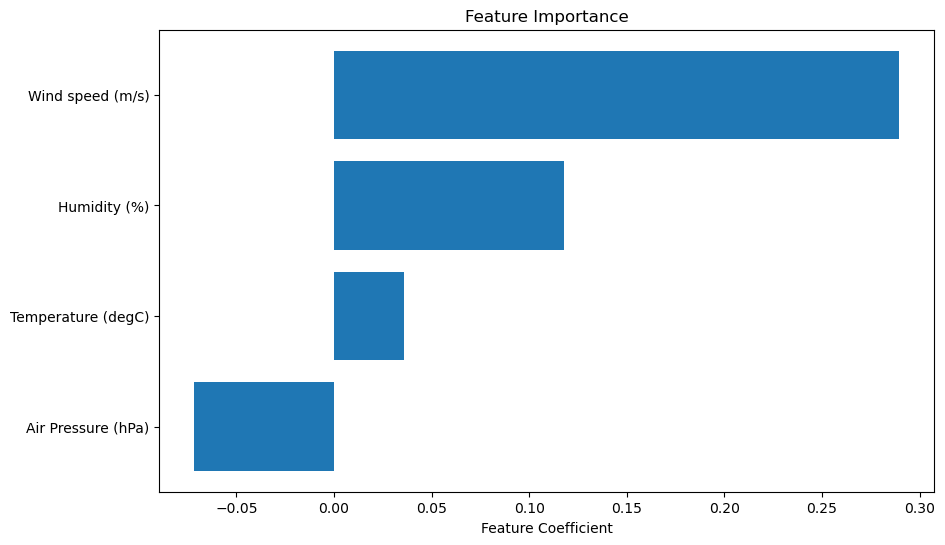

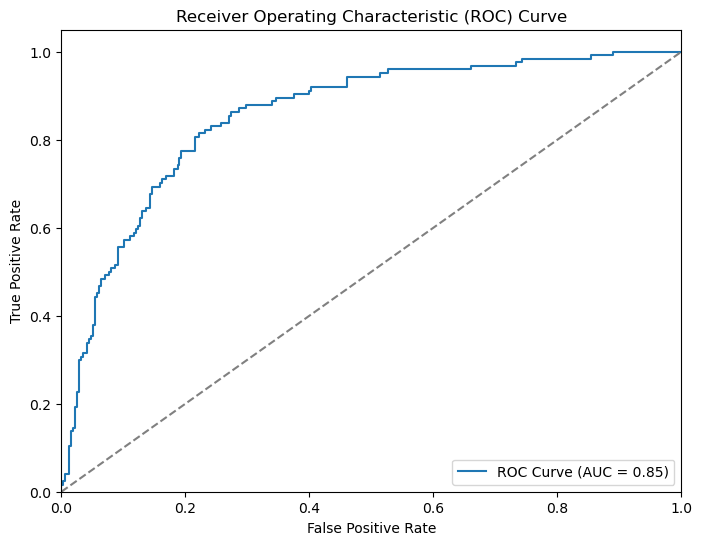

In [51]:
clf = SVC(kernel = 'linear', C =1.0)
clf.fit(X_train, y_train)


y_pred_train = clf.predict(X_train)

tr_hinge_loss = hinge_loss(y_train,y_pred_train)

y_pred_val = clf.predict(X_val)

val_hinge_loss = hinge_loss(y_val,y_pred_val)

y_pred_test = clf.predict(X_test)

test_hinge_loss = hinge_loss(y_test, y_pred_test)

conf_matrix = confusion_matrix(y_val, y_pred_val)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.savefig("SVCConfusionMatrix.png") # save as png


print(accuracy_score(y_val,y_pred_val))
# Feature Importance
# Sort features by their coefficients
coef = clf.coef_[0]
feature_names = X.columns
coef_indices = np.argsort(coef)
plt.show()

# Create a bar plot with sorted features
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in coef_indices], coef[coef_indices], align='center')
plt.xlabel('Feature Coefficient')
plt.title('Feature Importance')
plt.savefig("SVCFeatureImportance.png") # save as png


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig("SVC-ROC.png") # save as png



In [52]:
print(f"Thus we have training, validation, and test losses for the logistic regression: {tr_log_loss:.2f}, {val_log_loss:.2f}, {test_log_loss:.2f}\n and training, validation, and test losses for the SVM: {tr_hinge_loss:.2f}, {val_hinge_loss:.2f}, {test_hinge_loss:.2f}")


Thus we have training, validation, and test losses for the logistic regression: 6.93, 7.06, 5.99
 and training, validation, and test losses for the SVM: 0.85, 0.89, 0.79
